In [1]:
import os
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")

In [3]:
train.head()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),DEFCON_Level,ID
0,16,1,0.67,3,6.0,25.0,0.787812,324.36,1,862400.0,3,7570
1,8,1,0.11,2,38.0,48.0,0.419236,359.34,0,959200.0,4,12128
2,9,1,0.49,3,32.0,69.0,0.582232,332.84,1,836000.0,3,2181
3,7,0,0.30,2,31.0,52.0,0.589574,358.28,1,924000.0,3,5946
4,8,1,0.12,5,13.0,42.0,0.552863,364.64,0,968000.0,2,9054


In [4]:
train = train.set_index("ID")

In [5]:
test.head()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),ID
0,8,0,0.52,2,19.0,52.0,0.376652,319.06,1,976800.0,1
1,9,0,0.44,2,6.0,12.0,0.254772,351.92,1,1082400.0,10
2,8,0,0.44,3,7.0,18.0,0.472100,349.80,1,924000.0,14
3,10,0,0.39,2,3.0,13.0,0.478708,343.44,1,1003200.0,17
4,9,0,0.44,2,6.0,14.0,0.561674,346.62,1,924000.0,21


In [6]:
test = test.set_index("ID")

In [7]:
def make_bool(df,column):
    df[column] = np.where(df[column]>1,1,df[column])
    return df
    

In [8]:
train = make_bool(train,"Diplomatic_Meetings_Set")
train = make_bool(train,"Aircraft_Carriers_Responding")
test = make_bool(test,"Diplomatic_Meetings_Set")
test = make_bool(test,"Aircraft_Carriers_Responding")


In [9]:
label = train["DEFCON_Level"]
train = train.drop(columns="DEFCON_Level")


In [10]:
def new_ratio_feature(name, column1,column2,df):
    df[name] = df[column1]/df[column2]
    return df

In [11]:
train = new_ratio_feature("ratio_troops_per_threats","Troops_Mobilized(thousands)","Active_Threats",train)
train = new_ratio_feature("ratio_troops_allied_nations","Troops_Mobilized(thousands)","Allied_Nations",train)
train = new_ratio_feature("ratio_Allied_hostile_nations","Hostile_Nations","Allied_Nations",train)

test = new_ratio_feature("ratio_troops_per_threats","Troops_Mobilized(thousands)","Active_Threats",test)
test = new_ratio_feature("ratio_troops_allied_nations","Troops_Mobilized(thousands)","Allied_Nations",test)
test = new_ratio_feature("ratio_Allied_hostile_nations","Hostile_Nations","Allied_Nations",test)

In [12]:
train

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),ratio_troops_per_threats,ratio_troops_allied_nations,ratio_Allied_hostile_nations
ID,,,,,,,,,,,,,
7570,16,1,0.67,3,6.0,25.0,0.787812,324.36,1,862400.0,143733.333333,53900.000000,0.187500
12128,8,1,0.11,2,38.0,48.0,0.419236,359.34,0,959200.0,25242.105263,119900.000000,0.250000
2181,9,1,0.49,3,32.0,69.0,0.582232,332.84,1,836000.0,26125.000000,92888.888889,0.333333
5946,7,0,0.30,2,31.0,52.0,0.589574,358.28,1,924000.0,29806.451613,132000.000000,0.285714
9054,8,1,0.12,5,13.0,42.0,0.552863,364.64,0,968000.0,74461.538462,121000.000000,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11493,11,1,0.49,5,5.0,13.0,0.919971,329.66,1,1029600.0,205920.000000,93600.000000,0.454545
305,10,0,0.52,2,14.0,28.0,0.433921,348.74,1,1047200.0,74800.000000,104720.000000,0.200000
612,7,1,0.13,2,25.0,42.0,0.470631,366.76,1,941600.0,37664.000000,134514.285714,0.285714


In [13]:
label = label.apply(lambda x: x-1)

In [14]:
label.value_counts()

1    4270
2    3910
3    1212
0     498
4     110
Name: DEFCON_Level, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train, label, random_state=42,test_size=.1,stratify=label)

sm = SMOTE(random_state=12, sampling_strategy="not majority")
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

sm = ADASYN(random_state=12, sampling_strategy="minority")
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

y_train_res.value_counts()

X_train = x_train_res
y_train = y_train_res

In [16]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)


In [17]:
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth':11,
    'min_child_weight': 5,
    'eta':.01,
    'subsample': 1,
    'colsample_bytree': 1,

}

In [18]:
#params['eval_metric'] = "mlogloss"

In [19]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred),average="weighted")
    return 'f1_err', err

In [20]:
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtest, "Test")],
    early_stopping_rounds=20,
    feval=f1_eval
)

[0]	Test-merror:0.38300	Test-f1_err:0.39153
Multiple eval metrics have been passed: 'Test-f1_err' will be used for early stopping.

Will train until Test-f1_err hasn't improved in 20 rounds.
[1]	Test-merror:0.38100	Test-f1_err:0.38909
[2]	Test-merror:0.37700	Test-f1_err:0.38620
[3]	Test-merror:0.38200	Test-f1_err:0.39113
[4]	Test-merror:0.38100	Test-f1_err:0.39090
[5]	Test-merror:0.38600	Test-f1_err:0.39583
[6]	Test-merror:0.38800	Test-f1_err:0.39695
[7]	Test-merror:0.38600	Test-f1_err:0.39557
[8]	Test-merror:0.38000	Test-f1_err:0.39002
[9]	Test-merror:0.38600	Test-f1_err:0.39550
[10]	Test-merror:0.38300	Test-f1_err:0.39292
[11]	Test-merror:0.37800	Test-f1_err:0.38795
[12]	Test-merror:0.37800	Test-f1_err:0.38858
[13]	Test-merror:0.37500	Test-f1_err:0.38399
[14]	Test-merror:0.37900	Test-f1_err:0.38843
[15]	Test-merror:0.37800	Test-f1_err:0.38774
[16]	Test-merror:0.37800	Test-f1_err:0.38714
[17]	Test-merror:0.37900	Test-f1_err:0.38810
[18]	Test-merror:0.37700	Test-f1_err:0.38596
[19]	Tes

In [21]:
dtest1 = xgb.DMatrix(data=X_test)
dtest_pred = bst.predict(dtest1) + 1

In [22]:
y_test = y_test+1

In [23]:
def get_clasification_report():
    named_tuple = time.localtime()
    time_string = time.strftime("%m-%d-%Y_%H:%M:%S", named_tuple)
    classification_report1 = classification_report(y_test, dtest_pred,output_dict=True)
    classification_report1 = pd.DataFrame(classification_report1)
    classification_report1.to_csv('reports/reporte-'+time_string+'.csv',index=False)
    return classification_report1

In [24]:
get_clasification_report()

,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.444444,0.700855,0.602439,0.500000,0.0,0.634,0.449548,0.617541
recall,0.160000,0.768150,0.631714,0.421488,0.0,0.634,0.396270,0.634000
f1-score,0.235294,0.732961,0.616729,0.457399,0.0,0.634,0.408477,0.621225
support,50.000000,427.000000,391.000000,121.000000,11.0,0.634,1000.000000,1000.000000


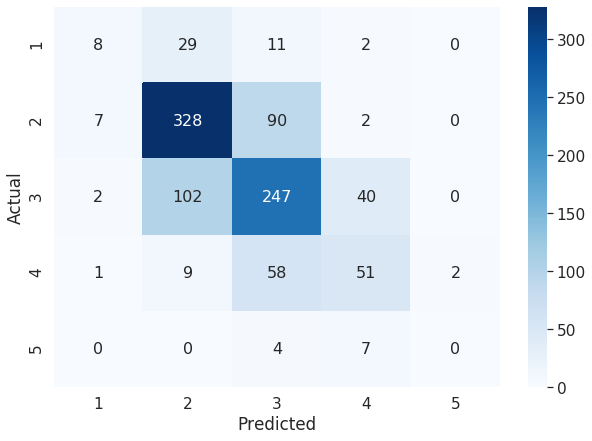

In [25]:
data = confusion_matrix(y_test, dtest_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='d')# font size


In [26]:
bst.get_fscore()

{'Percent_Of_Forces_Mobilized': 5904,
 'Inactive_Threats': 6714,
 'Aircraft_Carriers_Responding': 691,
 'Citizen_Fear_Index': 6398,
 'ratio_troops_per_threats': 5147,
 'Closest_Threat_Distance(km)': 6312,
 'Troops_Mobilized(thousands)': 6120,
 'ratio_Allied_hostile_nations': 1386,
 'Active_Threats': 2494,
 'ratio_troops_allied_nations': 3580,
 'Diplomatic_Meetings_Set': 1011,
 'Allied_Nations': 711,
 'Hostile_Nations': 391}

In [27]:
def make_pred(test):
    ids = test.index.values
    
    test = xgb.DMatrix(data=test)
    pred = bst.predict(test)

    pred = pd.DataFrame({'ID':ids,'DEFCON_Level':pred})
    pred["DEFCON_Level"] = pred["DEFCON_Level"].apply(lambda x: x+1)
    return pred

In [28]:
def save_prediction(pred):
    named_tuple = time.localtime() # get struct_time
    time_string = time.strftime("%m-%d-%Y_%H:%M:%S", named_tuple)
    
    try:
        os.mkdir('predictions')
    except:
        pass
    
    pred.to_csv('predictions/submit-'+time_string+'.csv',index=False)

In [29]:
pred = make_pred(test)
save_prediction(pred)